In [1]:
import os
import pickle
import prince
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties
from scipy.stats import chi2_contingency

# 獲取當前工作目錄
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
version3_path = os.path.join(parent_dir, "Version3")

# 暫時將工作目錄切換到 Version3
os.chdir(version3_path)

from sklearn.cluster import AgglomerativeClustering
from tdamapper.core_old import MapperAlgorithm
from tdamapper.cover import CubicalCover
from tdamapper.clustering import FailSafeClustering

from utils.utils_v3 import *
from utils.plots import *
from utils.preprocess import preprocess, process_other, get_unique_ids

try:
    myfont = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc")
    sns.set(style="whitegrid", font=myfont.get_name())
except Exception as e:
    print(e)

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

dataA2 = pd.read_csv("./Data/A2.csv", low_memory=False)
dataA1 = pd.read_csv("./Data/A1.csv")

[Errno 2] No such file or directory: 'C:\\System\\Library\\Fonts\\PingFang.ttc'


In [3]:
select_lst = [
    # 月份是為了篩選每個月2萬筆
    '發生月份',

    '天候名稱', '光線名稱', 
    '道路類別-第1當事者-名稱', '速限-第1當事者', 
    '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱',
    '肇事逃逸類別名稱-是否肇逃',
    '死亡受傷人數',

    # 大類別
    '道路型態大類別名稱', '事故位置大類別名稱',
    '車道劃分設施-分向設施大類別名稱',
    '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種', '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他',

    # 兩個欄位只有兩個觀察值不同
    '肇因研判大類別名稱-主要',
    # '肇因研判大類別名稱-個別',
    
    # 子類別
    # '道路型態子類別名稱', '事故位置子類別名稱', '事故類型及型態子類別名稱', '肇因研判子類別名稱-主要',
    # '當事者區分-類別-子類別名稱-車種', '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初',
    # '車輛撞擊部位子類別名稱-其他', '肇因研判子類別名稱-個別',
]

In [4]:
full_dataA1 = preprocess(dataA1, target='機車', lst=select_lst)
full_dataA2 = preprocess(dataA2, target='機車', lst=select_lst)
mapper_numpy, rbind_data, dummy_data, death, injuried = process_other(full_dataA1, full_dataA2, downsample=0.6, en=True)

43 10898
44 11152
42 10645
37 9377
33 8364
43 10898
54 13686
46 11659
39 9884
42 10645
[]
dummy_data: (107631, 131)


In [ ]:
from kmodes.kmodes import KModes

cost = []
all_results = {}
K = range(1, 6)

for k in K:

    km = KModes(
    n_clusters=k, 
    init='Huang',
    verbose=1,
    random_state=42,
    n_jobs=10
    )

    labels = km.fit_predict(rbind_data)
    cost.append(km.cost_)
    all_results[k] = {
        'cost': km.cost_,
        'labels': labels,
        'centroids': km.cluster_centroids_
    }

optimal_k = K[cost.index(min(cost))]
optimal_result = all_results[optimal_k]

# with open('Version3/Data/CarData/kmode_result.pickle', 'wb') as f:
#     pickle.dump(all_results, f)

plt.figure(figsize=(8, 5))
plt.plot(K, cost, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()

# save all_results
with open('./Data/Kmode/Motor.pkl', 'wb') as f:
    pickle.dump(all_results, f)

In [7]:
print(pd.Series(all_results[2]['labels']).value_counts())
rbind_data['Cluster'] = all_results[2]['labels']

1    57441
0    50190
dtype: int64


# MCA

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.112         3.20%                      3.20%
1              0.090         2.55%                      5.75%
2              0.074         2.10%                      7.84%
3              0.072         2.04%                      9.88%
4              0.066         1.89%                     11.77%
5              0.063         1.80%                     13.57%
6              0.061         1.75%                     15.32%
7              0.060         1.70%                     17.02%


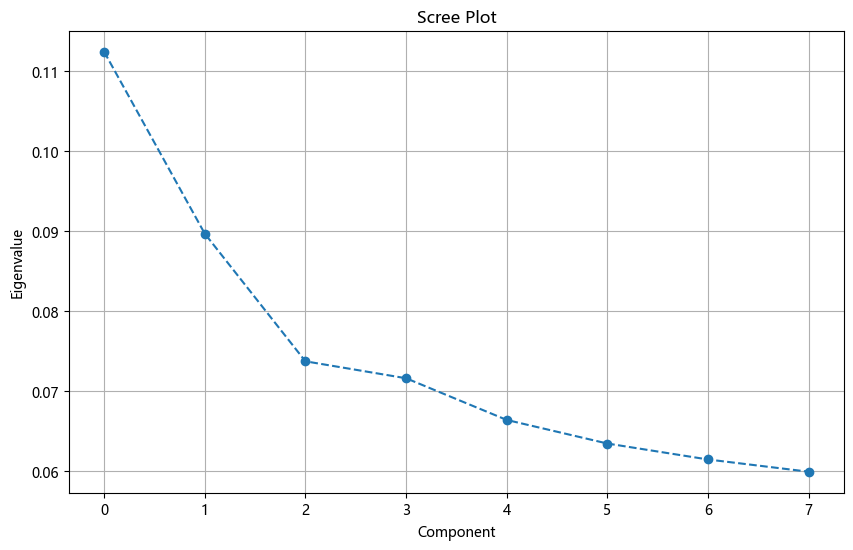

In [5]:
mca = prince.MCA(
    one_hot=False,
    n_components=8,
    n_iter=30,
    copy=True,
    check_input=True,
    random_state=42
    # random_state=43
)

mca.fit(dummy_data)
lens = mca.transform(dummy_data)

print(mca.eigenvalues_summary)

eigenvalues = mca.eigenvalues_

components = range(0, len(eigenvalues))

variance = mca.eigenvalues_summary['% of variance']

plt.figure(figsize=(10, 6))
plt.plot(components, eigenvalues, marker='o', linestyle='--')
plt.title("Scree Plot")
plt.xlabel("Component")
plt.ylabel("Eigenvalue")
plt.xticks(components)
plt.grid(True)
plt.show()

In [ ]:
plot_mca(mca, dummy_data)

In [9]:
grid_search_info = {
    'lens': lens,
    'mapper_numpy': mapper_numpy,
    'rbind_data': rbind_data,
}
with open('../ForMatrix/CalculatedData/Motor.pkl', 'wb') as f:
    pickle.dump(grid_search_info, f)

In [6]:
overlap = 2
interval = 10
detailed_results = []
silhouette_for_intervals = []

mapper_algo = MapperAlgorithm(
    cover=CubicalCover(
        n_intervals=interval,
        overlap_frac=overlap / 10
    ),
    clustering=FailSafeClustering(
        AgglomerativeClustering(
            n_clusters=2,
            linkage='ward'
        )
    ),
    n_jobs=14
)

mapper_info = mapper_algo.fit_transform(mapper_numpy, lens)
silhouette_for_intervals.append(mapper_info[1])
result = {
    "overlap": overlap,
    "interval": interval,
    "silhouette": mapper_info[1],
    "mapper_info": mapper_info
}
detailed_results.append(result)
detailed_results_df = pd.DataFrame(detailed_results)

07/25/2025 11:07:37 AM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 131)) while a minimum of 2 is required by AgglomerativeClustering.
07/25/2025 11:07:43 AM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 131)) while a minimum of 2 is required by AgglomerativeClustering.
07/25/2025 11:07:51 AM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 131)) while a minimum of 2 is required by AgglomerativeClustering.
07/25/2025 11:08:10 AM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 131)) while a minimum of 2 is required by AgglomerativeClustering.
07/25/2025 11:08:12 AM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 131)) while a minimum of 2 is required by AgglomerativeClustering.
07/25/2025 11:08:15 AM core WARNING: Unable to perform 

In [9]:
output_file = './Data/Mapper/motor_o2i10.pkl'

with open(output_file, 'rb') as f:
    detailed_results_df = pickle.load(f)
    
# with open(output_file, 'wb') as f:
#     pickle.dump(detailed_results_df, f)

# 目前分析使用的模型

In [13]:
for choose in select_lst:
    print(choose)
    try:
        mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'][0], rbind_data, seed=32, iterations=50,
                                        range_lst=[-0.07, 0.07, 0.1, -0.1], dim=3)
        mapper_plot = mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
        full_info = mapper_plotter.extract_data(rz=100)
        mapper_plotter.map_colors(choose, size=15, threshold=500)
        mapper_plotter.plot(choose, avg=False, set_label=True, size=3000)
    except Exception as e:
        print(e)
        continue

發生月份
'發生月份'
天候名稱
'天候名稱'
光線名稱
'光線名稱'
道路類別-第1當事者-名稱
'道路類別-第1當事者-名稱'
速限-第1當事者
'速限-第1當事者'
路面狀況-路面鋪裝名稱
'路面狀況-路面鋪裝名稱'
路面狀況-路面狀態名稱
'路面狀況-路面狀態名稱'
路面狀況-路面缺陷名稱
'路面狀況-路面缺陷名稱'
道路障礙-障礙物名稱
'道路障礙-障礙物名稱'
道路障礙-視距品質名稱
'道路障礙-視距品質名稱'
道路障礙-視距名稱
'道路障礙-視距名稱'
號誌-號誌種類名稱
'號誌-號誌種類名稱'
號誌-號誌動作名稱
'號誌-號誌動作名稱'
車道劃分設施-分道設施-快車道或一般車道間名稱
'車道劃分設施-分道設施-快車道或一般車道間名稱'
車道劃分設施-分道設施-快慢車道間名稱
'車道劃分設施-分道設施-快慢車道間名稱'
車道劃分設施-分道設施-路面邊線名稱
'車道劃分設施-分道設施-路面邊線名稱'
當事者屬-性-別名稱
'當事者屬-性-別名稱'
當事者事故發生時年齡
'當事者事故發生時年齡'
保護裝備名稱
'保護裝備名稱'
行動電話或電腦或其他相類功能裝置名稱
'行動電話或電腦或其他相類功能裝置名稱'
肇事逃逸類別名稱-是否肇逃
'肇事逃逸類別名稱-是否肇逃'
死亡受傷人數
'死亡受傷人數'
道路型態大類別名稱
'道路型態大類別名稱'
事故位置大類別名稱
'事故位置大類別名稱'
車道劃分設施-分向設施大類別名稱
'車道劃分設施-分向設施大類別名稱'
事故類型及型態大類別名稱
'事故類型及型態大類別名稱'
當事者區分-類別-大類別名稱-車種
'當事者區分-類別-大類別名稱-車種'
當事者行動狀態大類別名稱
'當事者行動狀態大類別名稱'
車輛撞擊部位大類別名稱-最初
'車輛撞擊部位大類別名稱-最初'
車輛撞擊部位大類別名稱-其他
'車輛撞擊部位大類別名稱-其他'
肇因研判大類別名稱-主要
'肇因研判大類別名稱-主要'


Mapper plot created.
Data extracted.
Colors mapped using predefined mapping.


c:\Users\USER\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



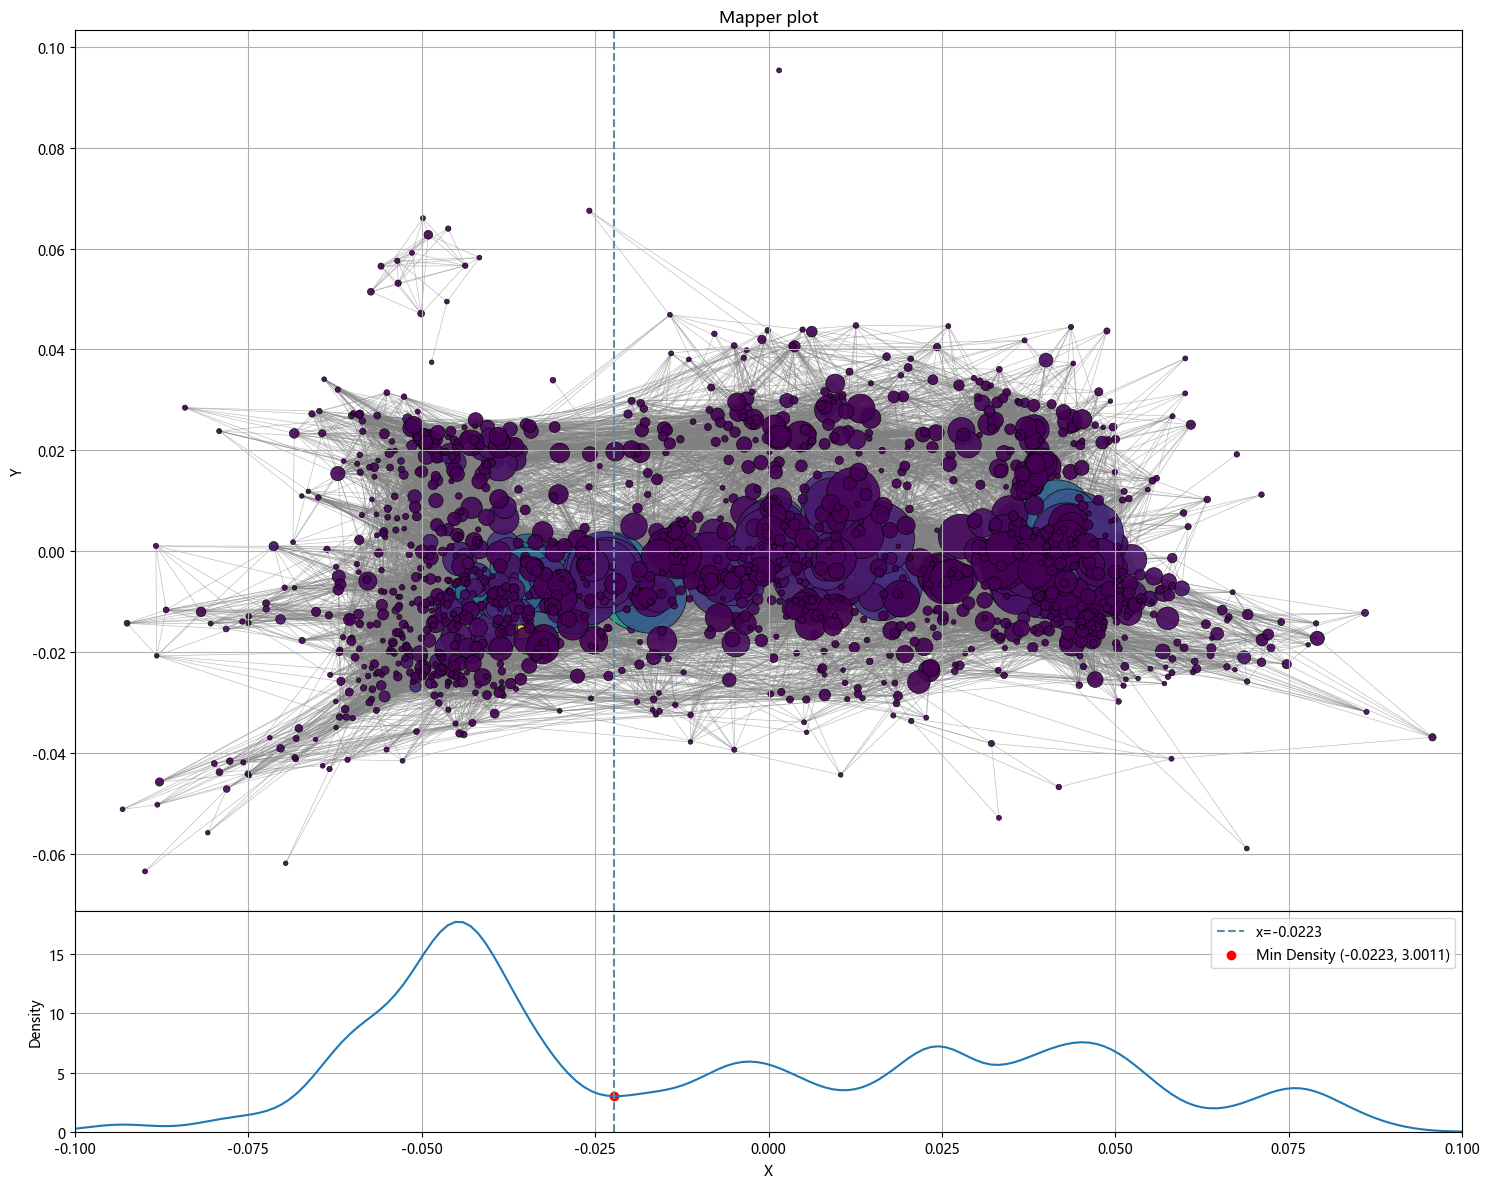

In [7]:
choose = '死亡'
rbind_data['死亡'] = death

mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'][0], rbind_data, seed=32, iterations=50,
                                range_lst=[-0.1, 0.1, 0.1, -0.1], dim=3)
mapper_plot = mapper_plotter.create_mapper_plot(choose, sum_of_data, avg=True)
full_info, label_out = mapper_plotter.extract_data(rz=100)
mapper_plotter.map_colors(choose, size=10, threshold=0)
mapper_plotter.plot_dens(choose, avg=True, set_label=False, size=3000, minimum_lst=[-0.025, 0.05])

In [ ]:
# choose = '顯著特徵'
# rbind_data['顯著特徵'] = rbind_data['道路型態子類別名稱'] + ',' + rbind_data['號誌-號誌動作名稱'] + ',' + rbind_data['天候名稱']
choose = 'Significant Features'
rbind_data['Significant Features'] = rbind_data['Road Category - Subcategory'] + ',' + rbind_data['Traffic Signal - Signal Operation'] + ',' + rbind_data["Weather Condition"]

mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'][0], rbind_data, seed=32, iterations=50,
                                range_lst=[-0.1, 0.1, 0.1, -0.1], dim=3)
mapper_plot = mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
full_info, label_out = mapper_plotter.extract_data(rz=100)
mapper_plotter.map_colors(choose, size=15, threshold=500)
mapper_plotter.plot(choose, avg=False, set_label=True, size=3000, anchor=1.33)

In [ ]:
full_info, label_out = mapper_plotter.extract_data(rz=100)
mapper_plotter.map_colors(choose, size=10, threshold=5)
mapper_plotter.plot(choose, avg=False, set_label=True, size=3000)

In [ ]:
choose = 'Cluster'

mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'][0], rbind_data, seed=32, iterations=50,
                                range_lst=[-0.1, 0.1, 0.1, -0.1], dim=3)
mapper_plot = mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
full_info, label_out = mapper_plotter.extract_data(rz=100)
mapper_plotter.map_colors(choose, size=5, threshold=5)
mapper_plotter.plot(choose, avg=False, set_label=True, size=3000)

# Polygon

07/25/2025 10:54:08 上午 legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


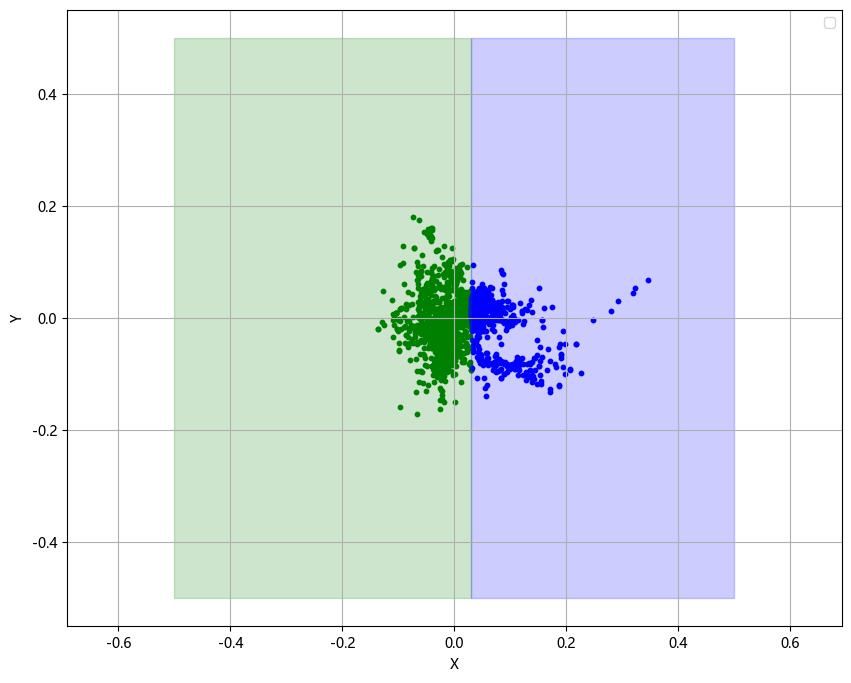

In [9]:
from shapely.geometry import Point, Polygon

threshold = 0.0299
x_max = 0.5
x_min = -0.5
y_max = 0.5
y_min = -0.5

rectangle1 = Polygon([(threshold, y_min), (x_min, y_min), (x_min, y_max), (threshold, y_max)])
rectangle2 = Polygon([(threshold, y_min), (threshold, y_max), (x_max, y_max), (x_max, y_min)])

th = 2
filtered_full_info = full_info[(full_info['y'] > -th) &
                               (full_info['y'] < th) &
                               (full_info['x'] > -th) &
                               (full_info['x'] < th)]

# 檢查每個點是否在任意一個區塊內
inside_indices_1 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle1), axis=1)
inside_indices_2 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle2), axis=1)

label_0 = filtered_full_info[inside_indices_1]
label_1 = filtered_full_info[inside_indices_2]

# 繪製數據點和矩形區塊
plt.figure(figsize=(10, 8))
plt.scatter(label_0['x'], label_0['y'], color='green', s=10)
plt.scatter(label_1['x'], label_1['y'], color='blue', s=10)
# 繪製矩形區塊
for rect, color, alpha in zip([rectangle1, rectangle2], 
                              ['green', 'blue'], 
                              [0.2, 0.2]):
    x, y = rect.exterior.xy
    plt.fill(x, y, color=color, alpha=alpha)
# 圖形調整
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

In [ ]:
plot_labels(label_0, label_1, label_out, title="Label and Outlier Visualization")

In [7]:
rbind_data['死亡'] = death
# 獲取每個label的index
count_0 = get_unique_ids(label_0)
count_1 = get_unique_ids(label_1)
count_out = get_unique_ids(label_out)

index_to_groups = {}

# 將索引與群體的關係記錄下來
for group_name, group_indexes in zip(
    ["full_0", "full_1", "full_out"],
    [count_0, count_1, count_out],
):
    for idx in group_indexes:
        if idx not in index_to_groups:
            index_to_groups[idx] = set()
        index_to_groups[idx].add(group_name)

# 找交集索引
intersection_indexes = {idx for idx, groups in index_to_groups.items() if len(groups) > 1}

# 移除交集的index
count_0 = [i for i in count_0 if i not in intersection_indexes]
count_1 = [i for i in count_1 if i not in intersection_indexes]
count_out = [i for i in count_out if i not in intersection_indexes]


full_0 = rbind_data.loc[count_0]
full_1 = rbind_data.loc[count_1]
full_out = rbind_data.loc[count_out]
overlap_data = rbind_data.loc[list(intersection_indexes)]

# 確認所有資料都被獲取
assert len(count_0) == full_0.shape[0]
assert len(count_1) == full_1.shape[0]
assert len(count_out) == full_out.shape[0]

print(full_0.shape[0] + full_1.shape[0] + full_out.shape[0] + overlap_data.shape[0])
print(rbind_data.shape[0])

107631
107631


In [8]:
print(full_0['死亡'].value_counts())
print(full_1['死亡'].value_counts())
print(full_out['死亡'].value_counts())
print(overlap_data['死亡'].value_counts())

0    69156
1      313
2        5
Name: 死亡, dtype: int64
0    32699
1       87
Name: 死亡, dtype: int64
0    2276
1      10
2       1
Name: 死亡, dtype: int64
0    3077
1       7
Name: 死亡, dtype: int64


In [9]:
full_info.to_csv('./Data/MotorData/full_info.csv', index=False)
full_0.to_csv('./Data/MotorData/full_0.csv', index=False)
full_1.to_csv('./Data/MotorData/full_1.csv', index=False)
full_out.to_csv('./Data/MotorData/full_out.csv', index=False)
overlap_data.to_csv('./Data/MotorData/overlap_data.csv', index=False)

In [ ]:
chi_lst = [
    '天候名稱', '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者', '路面狀況-路面鋪裝名稱',
    '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '肇事逃逸類別名稱-是否肇逃', '道路型態大類別名稱',
    '事故位置大類別名稱', '車道劃分設施-分向設施大類別名稱', '事故類型及型態大類別名稱',
    '車輛撞擊部位大類別名稱-其他']

results = []
rbind_data['death'] = death.apply(lambda x: 1 if x >= 1 else 0)
rbind_data['受傷'] = injuried

for chi_value in chi_lst:
    contingency_table = pd.crosstab(rbind_data[chi_value], rbind_data['death'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    if p < 0.01:  # 只篩選顯著結果
        results.append({'變數': chi_value, '卡方值': chi2, '自由度': dof, 'p值': p})

# 將結果轉為資料框
df_results = pd.DataFrame(results).sort_values(by='卡方值', ascending=True)

# 視覺化：條形圖
plt.figure(figsize=(10, 3.3))
plt.barh(df_results['變數'], df_results['卡方值'], alpha=0.7)
plt.xlabel('卡方值')
plt.ylabel('特徵')
plt.title('機車/自行車 顯著特徵 (p < 0.01)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
chi_lst = [
    'Weather Condition', 'Lighting Condition', 'Road Category - First Party - Name', 'Speed Limit - First Party', 'Road Surface Condition - Pavement Type',
    'Road Surface Condition - Surface State', 'Road Surface Condition - Surface Defects', 'Road Obstruction - Obstacle Type', 'Road Obstruction - Visibility Quality', 'Road Obstruction - Sight Distance',
    'Traffic Signal - Signal Type', 'Traffic Signal - Signal Operation', 'Lane Division Facility - Between Fast and General Lanes',
    'Lane Division Facility - Between Fast and Slow Lanes', 'Lane Division Facility - Road Edge Line', 'Party Attribute - Gender', 'Party Age at Accident',
    'Protective Equipment', 'Mobile Phone, Computer, or Other Similar Devices', 'Hit and Run - Yes or No', 'Road Category - Major Category',
    'Accident Location - Major Category', 'Lane Division Facility - Major Category', 'Accident Type and Form - Major Category', 'Party Classification - Vehicle Type',
    'Vehicle Impact Area - Other',
]

results = []
rbind_data['death'] = death.apply(lambda x: 1 if x >= 1 else 0)
rbind_data['受傷'] = injuried

for chi_value in chi_lst:
    contingency_table = pd.crosstab(rbind_data[chi_value], rbind_data['death'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    if p < 0.01:  # 只篩選顯著結果
        results.append({'變數': chi_value, '卡方值': chi2, '自由度': dof, 'p值': p})

# 將結果轉為資料框
df_results = pd.DataFrame(results).sort_values(by='卡方值', ascending=True)

# 視覺化：條形圖
plt.figure(figsize=(10, 3.3))
plt.barh(df_results['變數'], df_results['卡方值'], alpha=0.7)
plt.xlabel('Chi-square Value')
plt.ylabel('Feature')
plt.title('Motorcycle/bicycle Significant Features (p < 0.01)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()